In [71]:
# https://www.tensorflow.org/tutorials/audio/simple_audio

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
# from tensorflow.keras import layers
# from tensorflow.keras import models
# 이 방식은 오래된 import 방식
from IPython import display
import random

# Set the seed value for experiment reproducibility.
# 재현을 위해 시드를 설정합니다.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
# 다운로드

182082353/182082353 [==============================] - 5s 0us/step


In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)
# 아이템 목록

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [16]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print(f'총 개수: {num_samples}')
print(f'목소리 별 예시 개수: {len(tf.io.gfile.listdir(str(data_dir/commands[0])))}')
print('텐서 예시:', filenames[0])

총 개수: 8000
목소리 별 예시 개수: 1000
텐서 예시: tf.Tensor(b'data\\mini_speech_commands\\stop\\d8ee4734_nohash_0.wav', shape=(), dtype=string)


In [17]:
train_files = filenames[:int(num_samples * 0.8)]
val_files = filenames[int(num_samples * 0.8) : int(num_samples * 0.9)]
test_files = filenames[int(num_samples * -0.1):]
# 80 : 10 : 10

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [18]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape
# [샘플들, 채널들]
# 샘플 : 진폭 ( -32768 ~ 32767 )
# 채널 1 : 모노(mono), 2 : 스테레오

# 여기 예시들은 전부 mono

TensorShape([13654, 1])

In [30]:
def decode_audio(audio_binary):
	# Decode WAV-encoded audio files to `float32` tensors, normalized
	# to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
	# WAV 형식 오디오 파일을 텐서로 변환
	# -1.0 ~ 1.0 범위로 float 형 오디오와 샘플 레이트를 반환함
	audio, _ = tf.audio.decode_wav(contents=audio_binary)
	# Since all the data is single channel (mono), drop the `channels`
	# axis from the array.
	# 어차피 다 mono 채널이니, channels 를 드랍
	return tf.squeeze(audio, axis=-1)

In [29]:
def get_label(file_path):
	parts = tf.strings.split(
		input=file_path,
		sep=os.path.sep)
	# Note: You'll use indexing here instead of tuple unpacking to enable this
	# to work in a TensorFlow graph.
	# 상위 디렉토리를 참조하여 라벨 설정
	return parts[-2]

In [28]:
def get_waveform_and_label(file_path):
	label = get_label(file_path)
	audio_binary = tf.io.read_file(file_path)
	waveform = decode_audio(audio_binary)
	# 오디오 및 라벨 포함하는 거
	return waveform, label

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

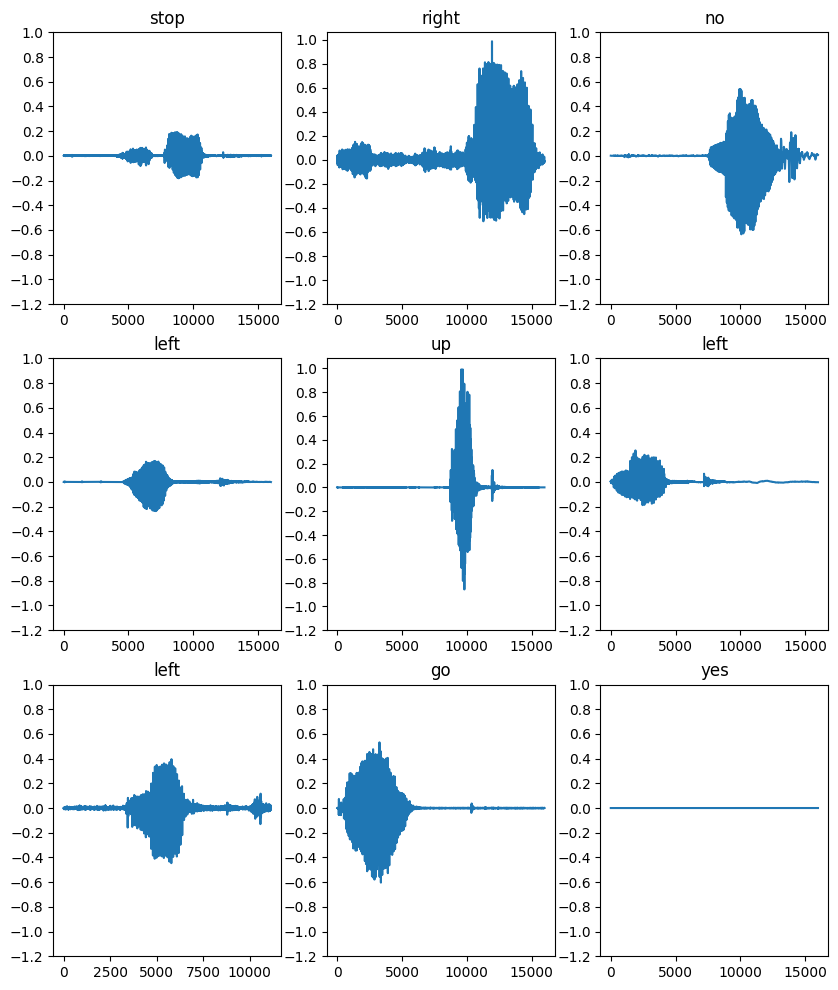

In [33]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
	r = i // cols
	c = i % cols
	ax = axes[r][c]
	ax.plot(audio.numpy())
	ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
	label = label.numpy().decode('utf-8')
	ax.set_title(label)

plt.show()
# 오디오 파형 플로팅

In [35]:
def get_spectrogram(waveform):
	# 파형을 스펙트럼으로

	# Zero-padding for an audio waveform with less than 16,000 samples.
	# 샘플이 16000개 미만인 오디오 파형에 대한 zero-padding
	input_len = 16000
	waveform = waveform[:input_len]
	zero_padding = tf.zeros(
		[16000] - tf.shape(waveform),
		dtype=tf.float32)
	# Cast the waveform tensors' dtype to float32.
	# float 로 변경
	waveform = tf.cast(waveform, dtype=tf.float32)
	# Concatenate the waveform with `zero_padding`, which ensures all audio
	# clips are of the same length.
	# 제로패딩으로 파형연결
	# 클립 길이 같음
	equal_length = tf.concat([waveform, zero_padding], 0)
	# Convert the waveform to a spectrogram via a STFT.
	# STFT 로 파형을 스펙트럼으로
	spectrogram = tf.signal.stft(
		equal_length, frame_length=255, frame_step=128)
	# Obtain the magnitude of the STFT.
	# STFT 크기 구하기
	spectrogram = tf.abs(spectrogram)
	# Add a `channels` dimension, so that the spectrogram can be used
	# as image-like input data with convolution layers (which expect
	# shape (`batch_size`, `height`, `width`, `channels`).
	spectrogram = spectrogram[..., tf.newaxis]
	return spectrogram

In [38]:
for waveform, label in waveform_ds.take(1):
	label = label.numpy().decode('utf-8')
	spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

# 스펙트럼 모양 , 오디오

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [41]:
def plot_spectrogram(spectrogram, ax):
	# 스펙트럼 표시하는 함수
	
	if len(spectrogram.shape) > 2:
		assert len(spectrogram.shape) == 3
		spectrogram = np.squeeze(spectrogram, axis=-1)
	# Convert the frequencies to log scale and transpose, so that the time is
	# represented on the x-axis (columns).
	# Add an epsilon to avoid taking a log of zero.
	log_spec = np.log(spectrogram.T + np.finfo(float).eps)
	height = log_spec.shape[0]
	width = log_spec.shape[1]
	X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
	Y = range(height)
	ax.pcolormesh(X, Y, log_spec)

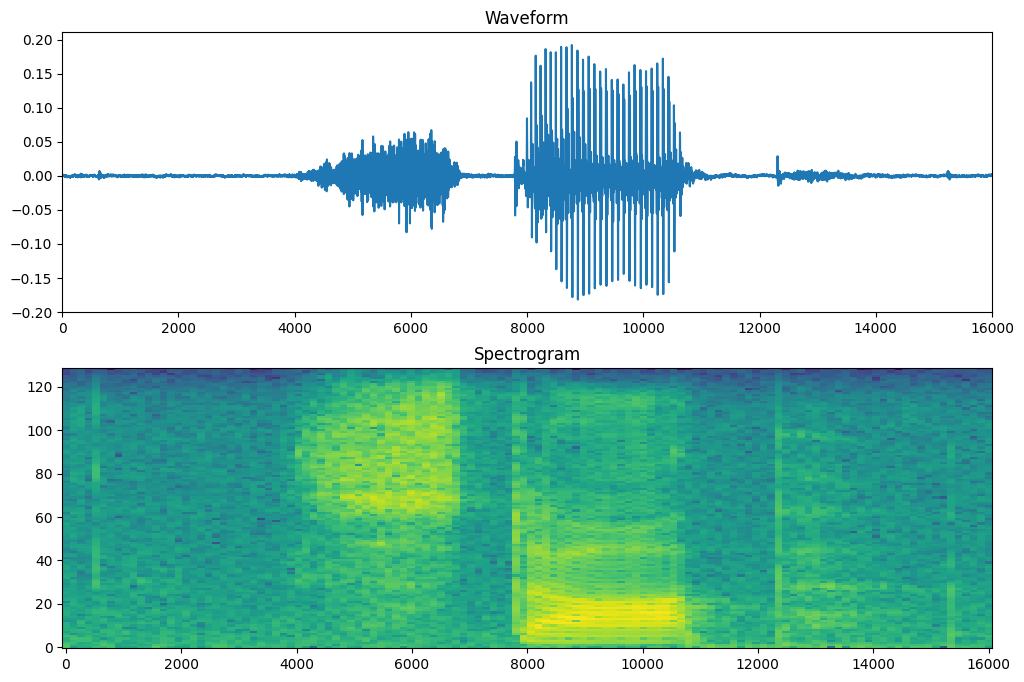

In [42]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()
# 보여주기

In [45]:
def get_spectrogram_and_label_id(audio, label):
	# 파형 데이터 세트를 스펙트로그램으로 변환하고 해당 레이블을 정수 ID로 변환하는 함수
	spectrogram = get_spectrogram(audio)
	label_id = tf.argmax(label == commands)
	return spectrogram, label_id

In [46]:
spectrogram_ds = waveform_ds.map(
	map_func=get_spectrogram_and_label_id,
	num_parallel_calls=AUTOTUNE)
# get_spectrogram_and_label_id 써서 매핑

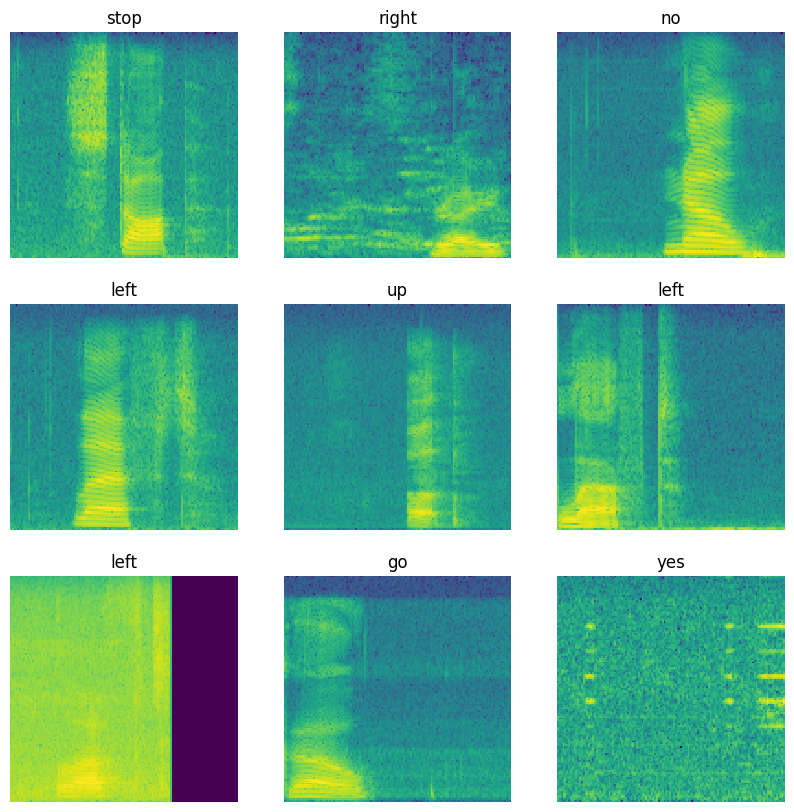

In [47]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
	r = i // cols
	c = i % cols
	ax = axes[r][c]
	plot_spectrogram(spectrogram.numpy(), ax)
	ax.set_title(commands[label_id.numpy()])
	ax.axis('off')

plt.show()

모델 빌드하고 학습시키기

In [48]:
def preprocess_dataset(files):
	files_ds = tf.data.Dataset.from_tensor_slices(files)
	output_ds = files_ds.map(
		map_func=get_waveform_and_label,
		num_parallel_calls=AUTOTUNE)
	output_ds = output_ds.map(
		map_func=get_spectrogram_and_label_id,
		num_parallel_calls=AUTOTUNE)
	return output_ds

In [49]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [50]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [51]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
# Dataset.cache 및 Dataset.prefetch 작업을 추가하여 모델을 훈련하는 동안 읽기 지연 시간을 줄입니다.

In [52]:
# 이 모델의 경우 오디오 파일을 스펙트로그램 이미지로 변환했으므로 간단한 CNN(컨볼루션 신경망)을 사용합니다.
# tf.keras.Sequential 모델은 다음과 같은 Keras 전처리 레이어를 사용합니다.

# tf.keras.layers.Resizing : 모델이 더 빠르게 학습할 수 있도록 입력을 다운샘플링합니다.
# tf.keras.layers.Normalization : 평균과 표준편차를 기반으로 이미지의 각 픽셀을 정규화합니다.

for spectrogram, _ in spectrogram_ds.take(1):
	input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
	layers.Input(shape=input_shape),
	# Downsample the input.
	layers.Resizing(32, 32),
	# Normalize.
	norm_layer,
	layers.Conv2D(32, 3, activation='relu'),
	layers.Conv2D(64, 3, activation='relu'),
	layers.MaxPooling2D(),
	layers.Dropout(0.25),
	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.5),
	layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [54]:
# Adam 옵티마이저와 교차 엔트로피 손실을 사용하여 Keras 모델을 구성합니다.
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'],
)

In [93]:
EPOCHS = 10
# 10번 학습
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=EPOCHS,
	# callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 10s 98ms/step - loss: 0.1868 - accuracy: 0.9352 - val_loss: 0.5425 - val_accuracy: 0.8537
Epoch 2/10
100/100 [==============================] - 10s 102ms/step - loss: 0.1811 - accuracy: 0.9355 - val_loss: 0.6040 - val_accuracy: 0.8400
Epoch 3/10
100/100 [==============================] - 10s 103ms/step - loss: 0.1594 - accuracy: 0.9469 - val_loss: 0.6088 - val_accuracy: 0.8500
Epoch 4/10
100/100 [==============================] - 10s 102ms/step - loss: 0.1474 - accuracy: 0.9509 - val_loss: 0.5766 - val_accuracy: 0.8612
Epoch 5/10
100/100 [==============================] - 10s 103ms/step - loss: 0.1524 - accuracy: 0.9461 - val_loss: 0.5486 - val_accuracy: 0.8462
Epoch 6/10
100/100 [==============================] - 11s 106ms/step - loss: 0.1410 - accuracy: 0.9517 - val_loss: 0.6140 - val_accuracy: 0.8550
Epoch 7/10
100/100 [==============================] - 11s 107ms/step - loss: 0.2515 - accuracy: 0.9134 - val_loss: 0.5531 - val_acc

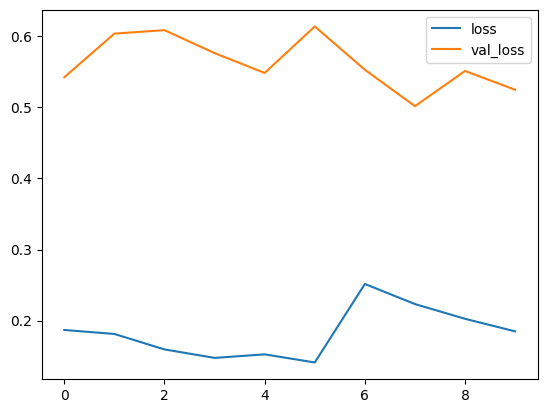

In [94]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [91]:
test_audio = []
test_labels = []

for audio, label in test_ds:
	test_audio.append(audio.numpy())
	test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [95]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 0s 17ms/step
Test set accuracy: 84%


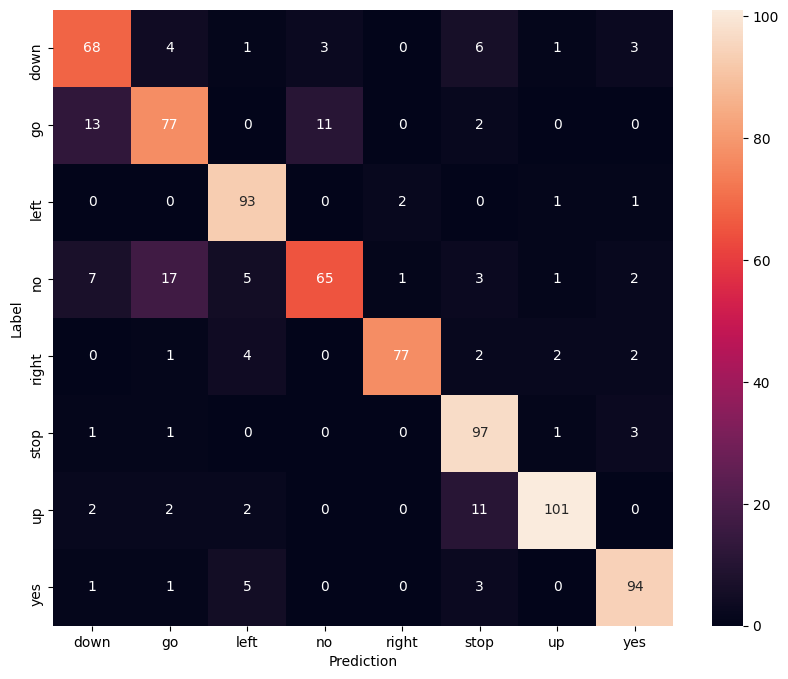

In [96]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
			xticklabels=commands,
			yticklabels=commands,
			annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
# 정오분류표 표시

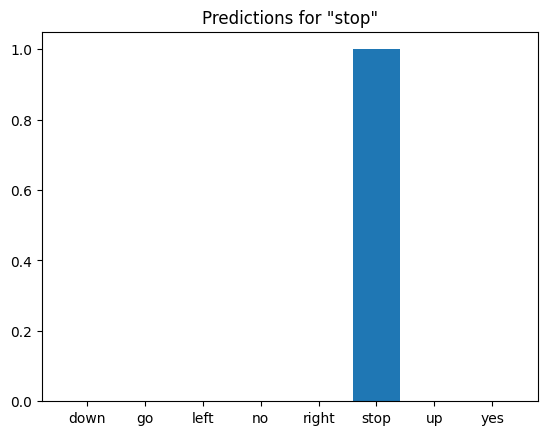

In [103]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'
# print(sample_file)
sample_file = random.choice(filenames).numpy().decode('utf-8')

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
	prediction = model(spectrogram)
	plt.bar(commands, tf.nn.softmax(prediction[0]))
	plt.title(f'Predictions for "{commands[label[0]]}"')
	plt.show()
# 예측

In [77]:
filenames[0].numpy().decode('utf-8')

'data\\mini_speech_commands\\stop\\d8ee4734_nohash_0.wav'